# Flu Vaccinations Project

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

**As the world struggles to vaccinate the global population against COVID-19, an understanding of how people’s backgrounds, opinions, and health behaviors are related to their personal vaccination patterns can provide guidance for future public health efforts. Your audience could be someone guiding those public health efforts.**

**This challenge: can you predict whether people got H1N1 and seasonal flu vaccines using data collected in the National 2009 H1N1 Flu Survey? This is a binary classification problem, but there are two potential targets: whether the survey respondent received the seasonal flu vaccine, or whether the respondent received the H1N1 flu vaccine. Please choose just one of these potential targets for your minimum viable project.**

## Business Problem

Vaccination, as one of the most successful public health interventions led to the elimination and control of diseases that were once common throughout the world. Despite overwhelming medical evidence and the unanimous position of medical professionals in favor of vaccination, the number of people skeptical about vaccination has grown in many countries in recent years. The consequence of this alarming trend is a decline in immunization coverage. Several outbreaks of infectious diseases have been linked to undervaccinated communities. The problem of expanding vaccine rejection has begun to be so widespread that it became the subject of many studies aimed at understanding the sources and correlations of attitudes toward vaccination.

The aim of this study is to predict how likely individuals are to receive their H1N1 flu vaccine, specifically, to predict the probabilities for h1n1_vaccine. We believe the prediction output of this study will give public health professionals and policy makers, as an end user, a clear understanding of factors associated with low vaccination rates. This in turn, capacitiate end users to systematically act on those features hindering people to get vaccinated. The methodologies used in these models can be used as a reference for future work, and also can be compared with different models for performance evaluation. In cognizant of the data type we have and our objectives, classification models, logistic regrssion, decision tree, random forest, kNN will be implemented. So as to classify exactly those who got H1N1 flu shot from those that did not, we need a higher accuracy of the model outputs, which indirectly shows very low false positive(those who considered vaccinated but did actually not get h1n1 flu shot) rate. This will be further assessed using the ROC curve, accuracy, precision, and confusion matrix.

---

**End Users**: Public health officials, and policy makers


**True business problem**:
- Predicting who is vaccinated or not accurately? (Deliverable: Model)
- What are the factors that influence people get H1N1 vaccine or not?  (Deliverable: Analysis)


**Context**:
- False negative in this context: Saying people did not get the vaccine when they actually did. 
- Outcome: Not a big problem

- False positive in this context: Saying people got the vaccine when they actually did not. 
- Outcome: Big problem

**Evaluation**:
Which metric (of the ones we've explore so far) would make sense to primarily use as we evaluate our models?

- **Accuracy**
- **Precision**
- Recall
- F1-Score

We can focus on accuracy for ease of use, but should also be maximizing our Precision score and **minimizing False Positives**, because false positives are a much more costly mistake than false negatives.

---

In [1]:
!pip install xgboost

In [2]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import category_encoders as ce

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost     # extreme gradient boosting

In [3]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [4]:
# To visualize the hidden columns in data
pd.options.display.max_columns=100

In [5]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, roc_auc='skip'):
    '''
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    roc_auc allows you to set how to calculate the roc_auc score: 
    'dec' for decision_function or 'proba' for predict_proba 
    If roc_auc == 'skip', then it ignores calculating the roc_auc_score
    
    Inputs:
        estimator: a fit sklearn-style model or pipeline
        X_tr: array or pandas dataframe
            training input variables
        X_te: array or pandas dataframe
            testing input variables
        y_tr: array or pandas series
            training output variable
        y_te: array or pandas series
            testing output variable
        roc_auc: str
            'skip': default, skips calculating roc_auc
            'dec': use decision_function to calculate roc_auc
            'proba': use predict_proba to calculate roc_auc
            
    Code source link: 
    https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb
    '''
    # Grab predictions
    tr_preds = estimator.predict(X_tr)
    te_preds = estimator.predict(X_te)
    
    # output needed for roc_auc_score
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': 
        train_out = estimator.decision_function(X_tr)
        test_out = estimator.decision_function(X_te)
    elif roc_auc == 'proba': 
        train_out = estimator.predict_proba(X_tr)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_te)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'")    
    
    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train Precision: {precision_score(y_tr, tr_preds)}")
    print(f"Train Recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train F1-Score: {f1_score(y_tr, tr_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
        
    print("*" * 10)
    print("Testing Scores:")
    print(f"Test Accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test Precision: {precision_score(y_te, te_preds)}")
    print(f"Test Recall: {recall_score(y_te, te_preds)}")
    print(f"Test F1-Score: {f1_score(y_te, te_preds)}")
    if type(test_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")    
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(estimator, X_te, y_te, cmap="plasma", normalize='true')

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [6]:
#pip install category_encoders

In [7]:
!ls ../../Data

LabelsandFeatures.txt
test_set_features.csv
training_set_features.csv
training_set_labels.csv


In [8]:
data1 = pd.read_csv('../../Data/training_set_features.csv')
data1.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [9]:
data2 = pd.read_csv('../../Data/training_set_labels.csv')
data2.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [10]:
data2['seasonal_vaccine'].value_counts(normalize=True)  

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

In [11]:
data2['h1n1_vaccine'].value_counts(normalize=True)   # class imbalance problem

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [12]:
df = data1.merge(data2, how='left', on='respondent_id')
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [14]:
df.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [15]:
# Exploring numerical cols
df.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,0.329735,0.283261,0.082590,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,0.470126,0.450591,0.275266,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000,1.000000


In [16]:
# Exploring object cols
df[[c for c in df.columns if df[c].dtype =='object']].describe()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
count,26707,25300,26707,26707,22284,25299,24665,25244,26707,26707,13377,13237
unique,5,4,4,2,3,2,2,3,10,3,21,23
top,65+ Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",fcxhlnwr,xtkaffoo
freq,6843,10097,21222,15858,12777,13555,18736,13560,4297,11645,2468,1778


In [17]:
# Exploring target distribution
df['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

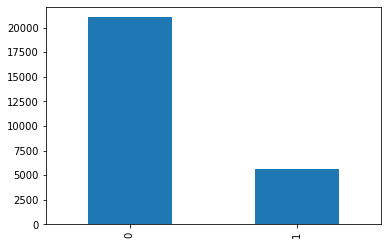

In [18]:
df['h1n1_vaccine'].value_counts().plot(kind='bar');

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?
- Can you pipeline your preparation steps to use them consistently in the modeling process?

In [19]:
#Define our X and y
X = df.drop(columns = ['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'], axis=1)
y = df['h1n1_vaccine']


# train test split
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [20]:
X.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [21]:
# Set up lists for columns requiring different treatment
num_cols = []
ohe_cols = []
freq_cols = []

for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [22]:
print(num_cols)
print('*'*100)
print(ohe_cols)
print('*'*100)
print(freq_cols)

['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']
****************************************************************************************************
['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa']
****************************************************************************************************
['hhs_geo_region', 'employment_industry', 'employment_occupation']


In [23]:
# Pipeline Preprocessing
num_transformer = Pipeline(steps=[
    ('num_imputer', IterativeImputer(max_iter=100, random_state=42)),
    ('minmaxscaler', MinMaxScaler())
    ])

ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe_encoder', OneHotEncoder(handle_unknown='ignore')) #no need to scale, ohe gives binary columns
])

freq_transformer = Pipeline(steps=[
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05)),
    # no need to scale, CountEncoder(normalize=True) scales them by normalizing
    ('freq_imputer', IterativeImputer(max_iter=100, random_state=42))
])

In [24]:
# Package those pieces together using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols)
    ])

In [25]:
# train test split
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [26]:
preprocessor.fit(X_tr)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral...
                                 ['age_group', 'education', 'race', 'sex',
                                  'in

In [27]:
# Just out of curiosity, see what this looks like 
X_tr_transformed = preprocessor.transform(X_tr)
X_tr_transformed.shape

(19228, 59)

In [28]:
pd.DataFrame(X_tr_transformed).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
0,1.000000,0.5,0.016076,0.963804,0.038064,0.894508,0.0,1.000000,0.0,0.116478,0.141558,1.0,0.0,1.000000,0.779010,0.75,0.296807,0.75,0.75,0.279800,0.75,0.333333,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.106407,0.499168,0.504213
1,0.666667,1.0,0.016076,0.000000,0.038064,0.894508,0.0,0.013143,1.0,0.116478,0.141558,0.0,0.0,0.110629,0.920662,0.75,0.765602,0.25,0.75,0.759933,0.25,0.333333,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.160235,0.340961,0.371854
2,0.333333,0.5,0.016076,0.963804,0.038064,0.894508,0.0,0.013143,0.0,1.000000,1.000000,0.0,0.0,0.110629,0.920662,0.75,0.296807,0.00,1.00,0.279800,0.00,0.333333,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.076659,0.499168,0.504213
3,0.333333,0.5,0.016076,0.963804,0.038064,0.894508,0.0,0.013143,1.0,0.116478,1.000000,0.0,0.0,0.110629,0.920662,0.75,0.296807,0.25,0.75,0.279800,0.25,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.160235,0.499168,0.504213
4,0.333333,1.0,0.016076,0.963804,0.038064,0.894508,0.0,0.013143,1.0,0.116478,0.141558,0.0,1.0,1.000000,0.920662,0.25,0.062409,0.00,0.75,0.279800,0.25,0.666667,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.160235,0.340961,0.371854


In [29]:
# pd.DataFrame(X_tr_transformed).isna().sum()  # we have no null values!

### Baseline Understanding

- What does a baseline, model-less prediction look like?

#### 1st Model - "Dummy" Model

In [30]:
dummy_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy="most_frequent"))
])

In [31]:
dummy_model.fit(X_tr, y_tr)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                

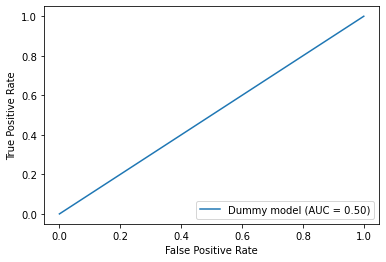

In [32]:
plot_roc_curve(dummy_model, X_tr, y_tr, name='Dummy model'); 

Training Scores:
Train Accuracy: 0.7875494071146245
Train Precision: 0.0
Train Recall: 0.0
Train F1-Score: 0.0
**********
Testing Scores:
Test Accuracy: 0.7874376039933444
Test Precision: 0.0
Test Recall: 0.0
Test F1-Score: 0.0


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


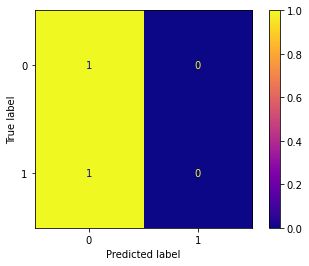

In [35]:
# Evaluate dummy model
evaluate(dummy_model, X_tr, X_te, y_tr, y_te, roc_auc='skip')

So, the mean accuracy is a little over 78% if we always guess the majority class, which is 0 in this case.

## Modeling Iterations

Now we will start to iterate over multiple models!

### MODEL 1: Decision Tree Classifier

In [36]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [37]:
cross_validate(clf, X_tr, y_tr, return_train_score=True)

{'fit_time': array([6.8258009 , 6.76046205, 6.55834889, 5.92640138, 6.3305192 ]),
 'score_time': array([0.15597391, 0.15789223, 0.14359879, 0.14078903, 0.15190434]),
 'test_score': array([0.77821113, 0.77197088, 0.76937077, 0.78127438, 0.77269181]),
 'train_score': array([1., 1., 1., 1., 1.])}

We see that, we have overfitting problem with DecisionTreeClassifier()!

In [38]:
# Let's do GridSearchCV
param_grid = {
    "classifier__max_depth": [1, 2, 5],
    "classifier__min_samples_split": [2, 10],
    "classifier__class_weight": ['balanced', None]   # we have class-imbalance issue, change the weights
}


In [39]:
grid = GridSearchCV(clf, param_grid, scoring=['f1','precision'], refit = 'f1')

In [40]:
output_clf = grid.fit(X_tr, y_tr)

In [41]:
output_clf.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 5,
 'classifier__min_samples_split': 2}

In [42]:
output_clf.best_estimator_.fit(X_tr, y_tr)

te_preds = output_clf.best_estimator_.predict(X_te)

In [43]:
# pd.DataFrame(grid.cv_results_)  # if you want to see the details of each combination in the grid

In [44]:
# output_clf.best_estimator_

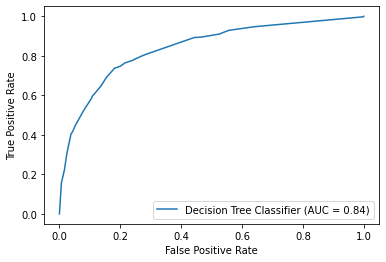

In [45]:
plot_roc_curve(output_clf.best_estimator_, X_te, y_te, name='Decision Tree Classifier'); 

Training Scores:
Train Accuracy: 0.7920220511753693
Train Precision: 0.5071858288770054
Train Recall: 0.7429620563035496
Train F1-Score: 0.6028404012315026
**********
Testing Scores:
Test Accuracy: 0.7886855241264559
Test Precision: 0.5019710906701709
Test Recall: 0.7475538160469667
Test F1-Score: 0.6006289308176102


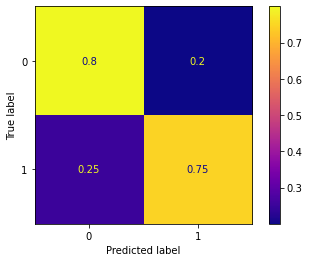

In [47]:
evaluate(output_clf.best_estimator_, X_tr, X_te, y_tr, y_te)

### MODEL 2: Logistic Regression

In [48]:
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500, random_state=42))
])

In [49]:
cross_validate(logreg, X_tr, y_tr, return_train_score=True)

{'fit_time': array([8.0830102 , 7.51557398, 6.95900249, 6.4039433 , 6.83472824]),
 'score_time': array([0.17083383, 0.1450212 , 0.15269184, 0.13978529, 0.19821739]),
 'test_score': array([0.83333333, 0.83515341, 0.82683307, 0.84577373, 0.82756827]),
 'train_score': array([0.83539202, 0.8340918 , 0.83545703, 0.83104726, 0.83559774])}

In [50]:
# Let's do GridSearchCV
param_grid = {
    "classifier__solver": ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    "classifier__C" : [1, 0.1, 0.01], # regularization parameter
    "classifier__class_weight": ['balanced', None]
}

In [51]:
grid = GridSearchCV(logreg, param_grid, scoring=['f1','precision'], refit = 'f1')

In [52]:
output_logreg = grid.fit(X_tr, y_tr)

In [53]:
output_logreg.best_params_

{'classifier__C': 1,
 'classifier__class_weight': 'balanced',
 'classifier__solver': 'lbfgs'}

In [54]:
output_logreg.best_estimator_.fit(X_tr, y_tr)

te_preds_logreg = output_logreg.best_estimator_.predict(X_te)

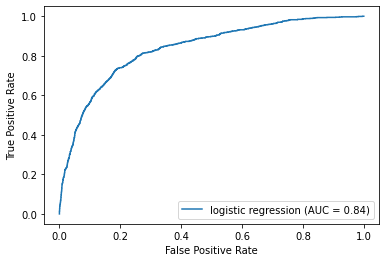

In [55]:
plot_roc_curve(output_logreg.best_estimator_, X_te, y_te, name='logistic regression');

Training Scores:
Train Accuracy: 0.775691699604743
Train Precision: 0.4817774936061381
Train Recall: 0.7378212974296205
Train F1-Score: 0.5829223479354027
**********
Testing Scores:
Test Accuracy: 0.778910149750416
Test Precision: 0.48693435309114086
Test Recall: 0.7475538160469667
Test F1-Score: 0.5897336935546121


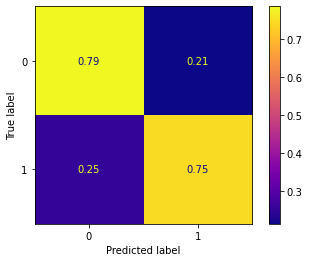

In [57]:
evaluate(output_logreg.best_estimator_, X_tr, X_te, y_tr, y_te)

In [58]:
# pd.DataFrame(grid.cv_results_)  # if you want to see the details of each combination in the grid

### MODEL 3: Random Forest

In [59]:
rfc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [60]:
cross_validate(rfc, X_tr, y_tr, return_train_score=True)

{'fit_time': array([8.58456135, 8.36606383, 7.60251093, 6.67112565, 6.78266287]),
 'score_time': array([0.19430399, 0.18360424, 0.16781783, 0.16170073, 0.15567923]),
 'test_score': array([0.84893396, 0.85361414, 0.84659386, 0.85019506, 0.84577373]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [61]:
# Let's do GridSearchCV
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth" : [2, 5], 
    "classifier__min_samples_leaf": [1, 2],
    "classifier__class_weight" :['balanced', 'balanced_subsample']  
    # class weight should be balanced or balanced_subsample - we have imbalance issue.
}


In [62]:
grid = GridSearchCV(rfc, param_grid, scoring=['f1','precision'], refit = 'f1')

In [63]:
output_rfc = grid.fit(X_tr, y_tr)

In [64]:
output_rfc.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 5,
 'classifier__min_samples_leaf': 1,
 'classifier__n_estimators': 200}

In [65]:
output_rfc.best_estimator_.fit(X_tr, y_tr)

te_preds_rfc = output_rfc.best_estimator_.predict(X_te)

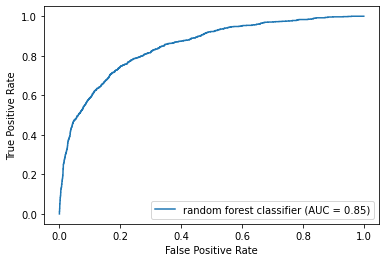

In [66]:
plot_roc_curve(output_rfc.best_estimator_, X_te, y_te, name='random forest classifier');

Training Scores:
Train Accuracy: 0.7942583732057417
Train Precision: 0.5107303277324904
Train Recall: 0.7515299877600979
Train F1-Score: 0.608161648177496
**********
Testing Scores:
Test Accuracy: 0.788269550748752
Test Precision: 0.5013245033112583
Test Recall: 0.7407045009784736
Test F1-Score: 0.5979462875197473


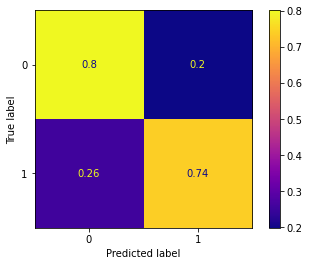

In [68]:
evaluate(output_rfc.best_estimator_, X_tr, X_te, y_tr, y_te)

### MODEL 4: Gradient Boosting Classifier

In [69]:
gbc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

In [70]:
cross_validate(gbc, X_tr, y_tr, return_train_score=True)

{'fit_time': array([10.61577821, 10.50165629, 10.66571927,  9.87104917, 10.51475286]),
 'score_time': array([0.11074424, 0.10669947, 0.1062994 , 0.10558248, 0.10735559]),
 'test_score': array([0.85595424, 0.85387415, 0.84971399, 0.85487646, 0.84889467]),
 'train_score': array([0.86074633, 0.86074633, 0.8617865 , 0.86036534, 0.86160047])}

In [71]:
# Let's do GridSearchCV
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth" : [1, 2, 5], 
    "classifier__learning_rate": [1, 0.1, 0.01],
}
# we have 2*3*3 = 18 many gradient boosting classifier models to run!

In [72]:
grid = GridSearchCV(gbc, param_grid, scoring=['f1','precision'], refit = 'f1') # 2*3*3*5 for CV

In [73]:
output_gbc = grid.fit(X_tr, y_tr)

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics

In [74]:
output_gbc.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 5,
 'classifier__n_estimators': 200}

In [75]:
output_gbc.best_estimator_.fit(X_tr, y_tr)

te_preds_gbc = output_gbc.best_estimator_.predict(X_te)

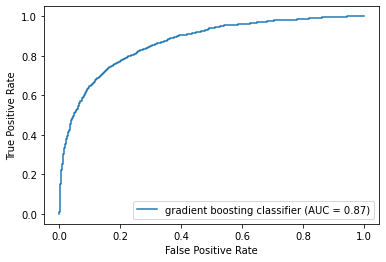

In [76]:
plot_roc_curve(output_gbc.best_estimator_, X_te, y_te, name='gradient boosting classifier');

Training Scores:
Train Accuracy: 0.895933014354067
Train Precision: 0.8400783289817232
Train Recall: 0.630110159118727
Train F1-Score: 0.7201007133864876
**********
Testing Scores:
Test Accuracy: 0.8548252911813644
Test Precision: 0.720108695652174
Test Recall: 0.5185909980430529
Test F1-Score: 0.602957906712173


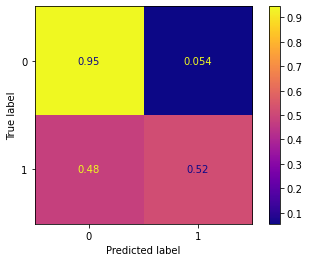

In [78]:
evaluate(output_gbc.best_estimator_, X_tr, X_te, y_tr, y_te)

### MODEL 5: kNN Classifier

In [79]:
kNN = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [80]:
cross_validate(kNN, X_tr, y_tr, return_train_score=True)

{'fit_time': array([9.0587883 , 7.19687343, 7.64434147, 7.15664363, 7.64661336]),
 'score_time': array([ 9.09708881,  9.56276298, 10.00513625,  8.75398588,  8.82294059]),
 'test_score': array([0.79407176, 0.79849194, 0.78731149, 0.79193758, 0.79089727]),
 'train_score': array([0.8417631 , 0.84247822, 0.84390846, 0.84612884, 0.8466489 ])}

In [81]:
# Let's do GridSearchCV
param_grid = {
    "classifier__n_neighbors": [5, 10],
    "classifier__weights" : ['uniform', 'distance'], 
    "classifier__p": [1, 2, 3],
}

In [82]:
grid = GridSearchCV(kNN, param_grid, scoring=['f1','precision'], refit = 'f1')

In [83]:
output_kNN = grid.fit(X_tr, y_tr)

KeyboardInterrupt: 

In [ ]:
output_kNN.best_params_

In [ ]:
output_kNN.best_estimator_.fit(X_tr, y_tr)

te_preds_kNN = output_kNN.best_estimator_.predict(X_te)

In [ ]:
plot_roc_curve(output_kNN.best_estimator_, X_te, y_te, name='k Nearest Neighborhood Classifier');

In [ ]:
evaluate(output_kNN.best_estimator_, X_tr, X_te, y_tr, y_te)

### MODEL 6: XG Boosting Classifier

In [84]:
xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgboost.XGBClassifier(random_state=42))
])

In [85]:
cross_validate(xgb, X_tr, y_tr, return_train_score=True)

{'fit_time': array([33.66285563, 25.08645034, 19.33605099, 17.20778298, 17.11731863]),
 'score_time': array([0.54289603, 0.44184518, 0.55847335, 0.45687413, 0.4688139 ]),
 'test_score': array([0.84711388, 0.85231409, 0.84607384, 0.85409623, 0.8426528 ]),
 'train_score': array([0.93856456, 0.93973475, 0.94753608, 0.93954365, 0.94331405])}

In [86]:
# Let's do GridSearchCV
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth" : [1, 2], 
    "classifier__learning_rate": [1, 0.1],
}


In [87]:
grid = GridSearchCV(xgb, param_grid, scoring=['f1','precision'], refit = 'f1')

In [88]:
output_xgb = grid.fit(X_tr, y_tr)

In [89]:
output_xgb.best_params_

{'classifier__learning_rate': 1,
 'classifier__max_depth': 2,
 'classifier__n_estimators': 100}

In [90]:
output_xgb.best_estimator_.fit(X_tr, y_tr)

te_preds_xgb = output_xgb.best_estimator_.predict(X_te)

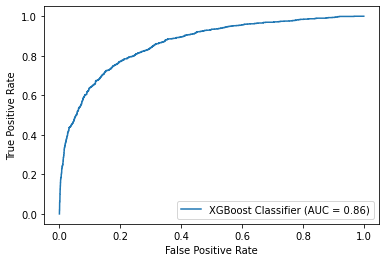

In [91]:
plot_roc_curve(output_xgb.best_estimator_, X_te, y_te, name='XGBoost Classifier');

Training Scores:
Train Accuracy: 0.8668088204701477
Train Precision: 0.7565656565656566
Train Recall: 0.5500611995104039
Train F1-Score: 0.6369950389794472
**********
Testing Scores:
Test Accuracy: 0.8508735440931781
Test Precision: 0.7126917712691772
Test Recall: 0.5
Test F1-Score: 0.5876940770557791


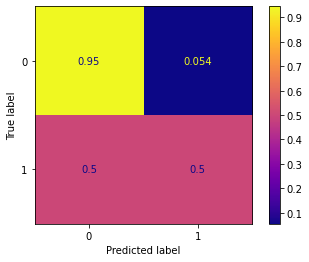

In [92]:
evaluate(output_xgb.best_estimator_, X_tr, X_te, y_tr, y_te,)

## Comparison of Model ROC Curves

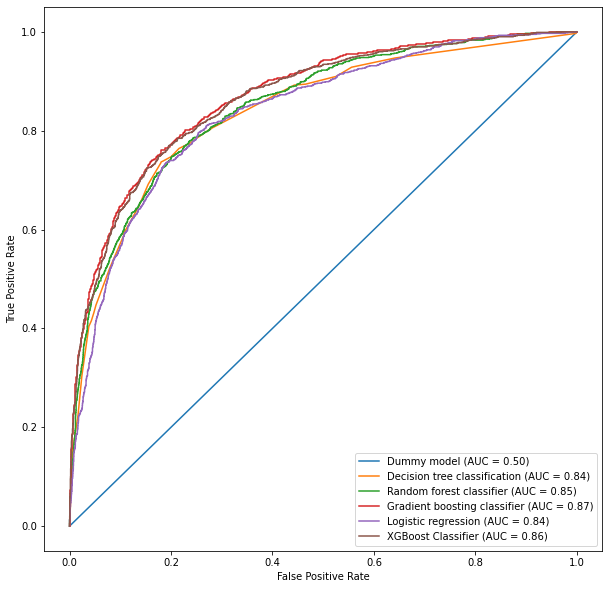

In [93]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_roc_curve(dummy_model, X_te, y_te,
               name='Dummy model', ax=ax)
#plot_roc_curve(output_kNN.best_estimator_, X_te, y_te, 
#               name='k Nearest Neighborhood classifier', ax=ax)
plot_roc_curve(output_clf.best_estimator_, X_te, y_te,
               name='Decision tree classification', ax=ax)
plot_roc_curve(output_rfc.best_estimator_, X_te, y_te, 
               name='Random forest classifier', ax=ax)
plot_roc_curve(output_gbc.best_estimator_, X_te, y_te, 
               name='Gradient boosting classifier', ax=ax)
plot_roc_curve(output_logreg.best_estimator_, X_te, y_te, 
               name='Logistic regression', ax=ax)
plot_roc_curve(output_xgb.best_estimator_, X_te, y_te, 
               name='XGBoost Classifier', ax=ax);

### 'Final' Model: Gradient Boosting Classifier

From the ROC curves comparison above, and confusion matrix of the method, we decided to choose Gradient Boosting Classifier as our final model. 

In [95]:
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(learning_rate =0.1, n_estimators=200, 
                                              max_depth=5,
                                              random_state=42))
])

In [97]:
output_final_model = final_model.fit(X_tr, y_tr)

In [98]:
hold_preds_final_model = final_model.predict(X_hold)

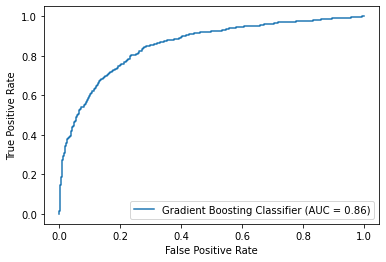

In [99]:
plot_roc_curve(final_model, X_hold, y_hold, name='Gradient Boosting Classifier');

Training Scores:
Train Accuracy: 0.8668088204701477
Train Precision: 0.7565656565656566
Train Recall: 0.5500611995104039
Train F1-Score: 0.6369950389794472
**********
Testing Scores:
Test Accuracy: 0.8450018719580681
Test Precision: 0.6917293233082706
Test Recall: 0.48677248677248675
Test F1-Score: 0.5714285714285714


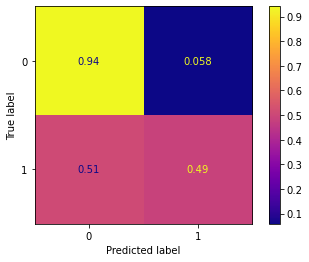

In [100]:
evaluate(final_model, X_tr, X_hold, y_tr, y_hold)

Our model did not overfit to the training set, we got similar AUC, precision and accuracy scores for the holdout set. We can generalize our model to unseen data.

### Feature Importance 

In [101]:
final_model['preprocessor']

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral...
                                 ['age_group', 'education', 'race', 'sex',
                                  'in

In [102]:
final_model['preprocessor'].fit_transform(X_tr).shape

(19228, 59)

In [103]:
pd.DataFrame(final_model['preprocessor'].fit_transform(X_tr)).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
0,1.000000,0.5,0.016076,0.963804,0.038064,0.894508,0.0,1.000000,0.0,0.116478,0.141558,1.0,0.0,1.000000,0.779010,0.75,0.296807,0.75,0.75,0.279800,0.75,0.333333,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.106407,0.499168,0.504213
1,0.666667,1.0,0.016076,0.000000,0.038064,0.894508,0.0,0.013143,1.0,0.116478,0.141558,0.0,0.0,0.110629,0.920662,0.75,0.765602,0.25,0.75,0.759933,0.25,0.333333,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.160235,0.340961,0.371854
2,0.333333,0.5,0.016076,0.963804,0.038064,0.894508,0.0,0.013143,0.0,1.000000,1.000000,0.0,0.0,0.110629,0.920662,0.75,0.296807,0.00,1.00,0.279800,0.00,0.333333,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.076659,0.499168,0.504213
3,0.333333,0.5,0.016076,0.963804,0.038064,0.894508,0.0,0.013143,1.0,0.116478,1.000000,0.0,0.0,0.110629,0.920662,0.75,0.296807,0.25,0.75,0.279800,0.25,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.160235,0.499168,0.504213
4,0.333333,1.0,0.016076,0.963804,0.038064,0.894508,0.0,0.013143,1.0,0.116478,0.141558,0.0,1.0,1.000000,0.920662,0.25,0.062409,0.00,0.75,0.279800,0.25,0.666667,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.160235,0.340961,0.371854


In [104]:
final_model['classifier'].feature_importances_

array([1.11492608e-02, 1.16198447e-02, 5.50352362e-03, 3.14729500e-03,
       5.05099935e-03, 3.02963189e-03, 2.89312301e-03, 3.00118538e-03,
       1.48503032e-03, 3.04514685e-01, 2.08734341e-02, 7.16371985e-03,
       8.33912735e-03, 3.79441735e-02, 1.63029370e-01, 1.19087364e-01,
       9.45289860e-02, 1.36968164e-02, 1.29758084e-02, 3.14383678e-02,
       1.11118335e-02, 8.91720376e-03, 7.43287360e-03, 2.67321629e-03,
       2.48171435e-03, 1.56316928e-03, 4.27999277e-03, 6.97286357e-03,
       2.28525154e-03, 5.63344331e-03, 5.39853837e-03, 1.34372476e-03,
       3.79157693e-03, 5.20576056e-03, 1.97704964e-03, 1.94393889e-03,
       2.94627450e-03, 2.53498163e-03, 1.98454794e-03, 1.53787250e-03,
       2.92085468e-03, 1.71900606e-03, 1.85018762e-03, 2.24159242e-03,
       2.11303485e-03, 2.87282421e-04, 8.72081871e-04, 2.57243362e-03,
       9.00035843e-04, 1.70701140e-03, 1.24244582e-03, 1.81431173e-03,
       1.98048835e-03, 1.89024640e-03, 1.68921617e-03, 2.29535857e-03,
      

In [105]:
final_model['preprocessor'].transformers_[0][2]

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [106]:
# we want to make sure we have the same num_cols as the preprocessed one!
num_cols

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [107]:
# These are ohe_transformed columns!
ohe_cols_transformed = final_model['preprocessor'].transformers_[1][1]['ohe_encoder'].get_feature_names(ohe_cols)
ohe_cols_transformed

array(['age_group_18 - 34 Years', 'age_group_35 - 44 Years',
       'age_group_45 - 54 Years', 'age_group_55 - 64 Years',
       'age_group_65+ Years', 'education_12 Years',
       'education_< 12 Years', 'education_College Graduate',
       'education_Some College', 'education_Unknown', 'race_Black',
       'race_Hispanic', 'race_Other or Multiple', 'race_White',
       'sex_Female', 'sex_Male',
       'income_poverty_<= $75,000, Above Poverty',
       'income_poverty_> $75,000', 'income_poverty_Below Poverty',
       'income_poverty_Unknown', 'marital_status_Married',
       'marital_status_Not Married', 'marital_status_Unknown',
       'rent_or_own_Own', 'rent_or_own_Rent', 'rent_or_own_Unknown',
       'employment_status_Employed',
       'employment_status_Not in Labor Force',
       'employment_status_Unemployed', 'employment_status_Unknown',
       'census_msa_MSA, Not Principle  City',
       'census_msa_MSA, Principle City', 'census_msa_Non-MSA'],
      dtype=object)

In [108]:
final_model['preprocessor'].transformers_[2][2]

['hhs_geo_region', 'employment_industry', 'employment_occupation']

In [109]:
freq_cols

['hhs_geo_region', 'employment_industry', 'employment_occupation']

In [110]:
final_cols = [*num_cols, *ohe_cols_transformed, *freq_cols]
final_cols

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children',
 'age_group_18 - 34 Years',
 'age_group_35 - 44 Years',
 'age_group_45 - 54 Years',
 'age_group_55 - 64 Years',
 'age_group_65+ Years',
 'education_12 Years',
 'education_< 12 Years',
 'education_College Graduate',
 'education_Some College',
 'education_Unknown',
 'race_Black',
 'race_Hispanic',
 'race_Other or Multiple',
 'race_White',
 'sex_Female',
 'sex_Male',
 'income_poverty_<= $75,000, Above Poverty',
 'income

In [111]:
# putting together the final cols and the feature importances!
# plus sorting by feature importances
pd.DataFrame.from_dict(dict(zip(final_cols, final_model['classifier'].feature_importances_)), 
                       orient='index').sort_values(by=0, ascending=False)

,0
doctor_recc_h1n1,0.304515
health_insurance,0.163029
opinion_h1n1_vacc_effective,0.119087
opinion_h1n1_risk,0.094529
health_worker,0.037944
opinion_seas_risk,0.031438
doctor_recc_seasonal,0.020873
hhs_geo_region,0.015760
opinion_h1n1_sick_from_vacc,0.013697
opinion_seas_vacc_effective,0.012976


## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- How could the stakeholder use your model effectively?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
